In [6]:
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import bisect

## Libraries and Constants


In [7]:
TENOR_MAPPING = {"m": 1 / 12, "y": 1}

## Input Data


In [8]:
file_directory = "../data/IR data.xlsx"

## 1. OIS Curve Fitting


In [18]:
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import fsolve


TENOR_MAPPING = {"m": 1 / 12, "y": 1}


class OISBootstrapping:
    """
    This is a class to bootstrap OIS curves in order to generate
    its respective OIS Discount Factor
    """

    def __init__(self, filename: str, fixed_leg_period: float = 1):
        """
        Initialization of OISBootstrapping class

        Args:
            filename (str): path of the OIS data
            fixed_leg_period (float, optional): the period of fixed leg payment. Defaults to 1.
        """
        self.df_ois = self.read_file(filename)
        self.day_count_convention = {"accrual_period": 30, "annual_days": 360}
        self.floating_leg_period = 1 / 360
        self.fixed_leg_period = fixed_leg_period

        self.format_data()
        self.bootstrap_below_fixed_leg_period()
        self.bootstrap_above_fixed_leg_period()
        self.plot_discount_curve()
        # print(self.df_ois)

    def read_file(self, filename: str) -> pd.DataFrame:
        """This function reads text file and returns the data as a DataFrame

        Args:
            filename (str): path of the OIS data

        Returns:
            pd.DataFrame: OIS data
        """
        df_ois = pd.read_excel(filename, sheet_name="OIS")
        return df_ois

    def format_data(self):
        """This function formats OIS data"""
        df_ois_formatted = self.df_ois.copy().iloc[:, :3]
        df_ois_formatted["Tenor"] = (
            df_ois_formatted["Tenor"]
            .str.extract(r"(\d+)([my])")
            .apply(lambda x: int(x[0]) * TENOR_MAPPING[x[1]], axis=1)
        )
        df_ois_formatted["Tenor Delta"] = df_ois_formatted["Tenor"] - df_ois_formatted[
            "Tenor"
        ].shift().fillna(0)
        df_ois_formatted["Discount Factor"] = 0.0
        df_ois_formatted["Overnight Rate"] = 0.0
        df_ois_formatted["PV Float"] = 0.0
        df_ois_formatted["PV Fix"] = 0.0

        self.df_ois = df_ois_formatted.copy()

    def get_compounded_return_func(self, year_num: float) -> Callable[[float], float]:
        """This function returns a function that calculates the daily compounded return
        based on a certain number of years
        given an overnight rate

        Args:
            year_num (float): number of years

        Returns:
            Callable[[float], float]: a function that
                takes in the overnight rate and computes the compounded return
        """
        return lambda overnight_rate: (
            1 + overnight_rate / self.day_count_convention["annual_days"]
        ) ** (year_num * self.day_count_convention["annual_days"])

    def get_current_discount_factor_func(
        self, prev_discount_factor: float, year_diff: float
    ) -> Callable[[float], float]:
        """This function returns a function that calculates the current discount factor
        based on the previous discount factor
        and the year difference between the previous and the current discount factor
        given an overnight rate

        Args:
            prev_discount_factor (float): previous discount factor
            year_num (float): number of years

        Returns:
            Callable[[float], float]: a function
        """
        return (
            lambda overnight_rate: prev_discount_factor
            * 1
            / self.get_compounded_return_func(year_diff)(overnight_rate)
        )

    def bootstrap_below_fixed_leg_period(self):
        """This function bootstraps the OIS curve in order to get the discount factors
        for the tenors below the fixed leg period
        """
        df_ois_below_fixed_leg_period = self.df_ois[
            self.df_ois["Tenor"] <= self.fixed_leg_period
        ]
        for index, ois_row in df_ois_below_fixed_leg_period.iterrows():
            tenor, rate, tenor_delta = (
                ois_row["Tenor"],
                ois_row["Rate"],
                ois_row["Tenor Delta"],
            )
            prev_discount_factor = (
                1 if index == 0 else self.df_ois.loc[index - 1]["Discount Factor"]
            )
            current_discount_factor_function = self.get_current_discount_factor_func(
                prev_discount_factor, tenor_delta
            )

            # Fixed Leg
            def present_value_fixed_func(f):
                return current_discount_factor_function(f) * tenor * rate

            # Floating Leg
            prev_ois_data = self.df_ois.loc[: index - 1]
            prev_compounded_returns = np.prod(
                [
                    self.get_compounded_return_func(ois_row["Tenor Delta"])(
                        ois_row["Overnight Rate"]
                    )
                    for _, ois_row in prev_ois_data.iterrows()
                ]
            )

            def present_value_floating_func(f):
                return current_discount_factor_function(f) * (
                    prev_compounded_returns
                    * self.get_compounded_return_func(tenor_delta)(f)
                    - 1
                )

            f = fsolve(
                lambda f: (
                    present_value_fixed_func(f) - present_value_floating_func(f)
                ),
                1e-9,
            )[0]

            self.df_ois.loc[index, "Overnight Rate"] = f
            self.df_ois.loc[index, "Discount Factor"] = (
                current_discount_factor_function(f)
            )
            self.df_ois.loc[index, "PV Float"] = present_value_floating_func(f)
            self.df_ois.loc[index, "PV Fix"] = present_value_fixed_func(f)

    def bootstrap_above_fixed_leg_period(self):
        """This function bootstraps the OIS curve in order to get the discount factors
        for the tenors above the fixed leg period
        """
        df_ois_above_fixed_leg_period = self.df_ois[
            self.df_ois["Tenor"] > self.fixed_leg_period
        ]
        for index, ois_row in df_ois_above_fixed_leg_period.iterrows():
            tenor, rate, tenor_delta = (
                ois_row["Tenor"],
                ois_row["Rate"],
                ois_row["Tenor Delta"],
            )
            prev_discount_factor, prev_tenor = self.df_ois.loc[
                index - 1, ["Discount Factor", "Tenor"]
            ]
            current_discount_factor_function = self.get_current_discount_factor_func(
                prev_discount_factor, tenor_delta
            )

            prev_discount_factor_dict = {}
            for i in np.arange(
                self.fixed_leg_period,
                tenor,
                self.fixed_leg_period,
            ):
                discount_factor = self.df_ois[self.df_ois["Tenor"] == i][
                    "Discount Factor"
                ].values

                if len(discount_factor) == 0:
                    # Discount factor of a certain tenor is not found in the dataframe.
                    # As such, the value needs to be interpolated
                    if i < prev_tenor:
                        ois_row_before_i = self.df_ois[self.df_ois["Tenor"] < i].iloc[
                            -1, :
                        ]
                        ois_row_after_i = self.df_ois[self.df_ois["Tenor"] > i].iloc[
                            0, :
                        ]
                        prev_discount_factor_dict[i] = (
                            self.interpolate_discount_factor_between_tenor(
                                ois_row_before_i["Discount Factor"],
                                ois_row_after_i["Discount Factor"],
                                ois_row_before_i["Tenor"],
                                ois_row_after_i["Tenor"],
                                i,
                            )
                        )
                    else:
                        prev_discount_factor_dict[i] = (
                            lambda f, interp_tenor: self.interpolate_discount_factor_between_tenor(
                                prev_discount_factor,
                                current_discount_factor_function(f),
                                prev_tenor,
                                tenor,
                                interp_tenor,
                            )
                        )

                else:
                    prev_discount_factor_dict[i] = discount_factor[0]

            # Fixed Leg
            def present_value_fixed_func(f):
                return (
                    sum(
                        val(f, key) if callable(val) else val
                        for key, val in prev_discount_factor_dict.items()
                    )
                    + current_discount_factor_function(f)
                ) * rate

            # Floating Leg
            prev_present_value_floating_cumulative = self.df_ois.loc[
                index - 1, "PV Float"
            ]

            def prev_interpolated_discount_factors(f):
                prev_interpolated_discount_factors = []
                for i in np.arange(
                    prev_tenor + self.fixed_leg_period,
                    tenor,
                    self.fixed_leg_period,
                ):
                    prev_interpolated_discount_factors.append(
                        prev_discount_factor_dict[i](f, i)
                    )
                return sum(prev_interpolated_discount_factors)

            def present_value_floating_func(f):
                return prev_present_value_floating_cumulative + (
                    prev_interpolated_discount_factors(f)
                    + current_discount_factor_function(f)
                ) * (self.get_compounded_return_func(self.fixed_leg_period)(f) - 1)

            f = fsolve(
                lambda f: (
                    present_value_fixed_func(f) - present_value_floating_func(f)
                ),
                1e-9,
            )[0]

            self.df_ois.loc[index, "Overnight Rate"] = f
            self.df_ois.loc[index, "Discount Factor"] = (
                current_discount_factor_function(f)
            )
            self.df_ois.loc[index, "PV Float"] = present_value_floating_func(f)
            self.df_ois.loc[index, "PV Fix"] = present_value_fixed_func(f)

    def interpolate_discount_factor_between_tenor(
        self,
        prev_discount_factor: float,
        next_discount_factor: float,
        prev_tenor: float,
        next_tenor: float,
        curr_tenor: float,
    ) -> float:
        """This function interpolates the discount factor of a tenor
        between two different discount factors

        Args:
            prev_discount_factor (float): previous discount factor
            next_discount_factor (float): next discount factor
            prev_tenor (float): previous tenor
            next_tenor (float): next tenor
            curr_tenor (float): current tenor

        Returns:
            float: interpolated discount factor
        """
        return prev_discount_factor + (next_discount_factor - prev_discount_factor) * (
            curr_tenor - prev_tenor
        ) / (next_tenor - prev_tenor)

    def plot_discount_curve(self):
        """This function plots the boostrapped discount curve of the OIS data"""
        plt.style.use("classic")
        plt.plot(self.df_ois["Tenor"], self.df_ois["Discount Factor"])
        plt.scatter(self.df_ois["Tenor"], self.df_ois["Discount Factor"])
        plt.xlim(self.df_ois["Tenor"].min(), self.df_ois["Tenor"].max())
        plt.ylim(
            self.df_ois["Discount Factor"].min(), self.df_ois["Discount Factor"].max()
        )
        plt.xlabel("Tenor (years)")
        plt.ylabel("OIS Discount Factor")
        plt.title("OIS Discount Factor vs Tenor")
        plt.grid()
        plt.savefig("output/OIS Discount Curve.png")

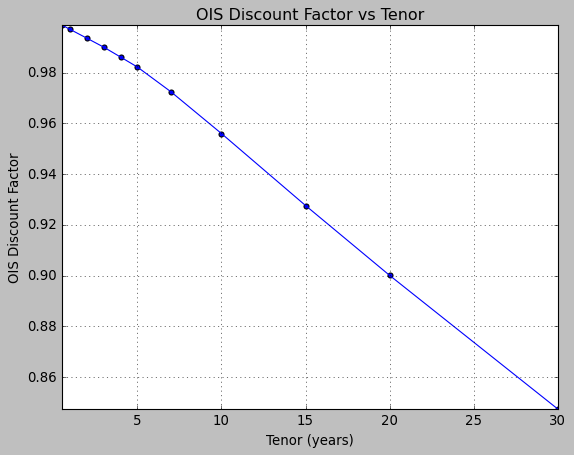

In [19]:
ois_bootstrapping = OISBootstrapping(file_directory)
df_ois = ois_bootstrapping.df_ois

In [20]:
df_ois

,Tenor,Product,Rate,Tenor Delta,Discount Factor,Overnight Rate,PV Float,PV Fix
0,0.5,OIS,0.00250,0.5,0.998752,0.002498,0.001248,0.001248
1,1.0,OIS,0.00300,0.5,0.997009,0.003493,0.002991,0.002991
2,2.0,OIS,0.00325,1.0,0.993531,0.003495,0.006469,0.006469
3,3.0,OIS,0.00335,1.0,0.990015,0.003545,0.009985,0.009985
4,4.0,OIS,0.00350,1.0,0.986117,0.003946,0.013883,0.013883
5,5.0,OIS,0.00360,1.0,0.982184,0.003996,0.017816,0.017816
6,7.0,OIS,0.00400,2.0,0.972406,0.005003,0.027594,0.027594
7,10.0,OIS,0.00450,3.0,0.955977,0.005680,0.044023,0.044023
8,15.0,OIS,0.00500,5.0,0.927614,0.006024,0.072389,0.072389
9,20.0,OIS,0.00525,5.0,0.900080,0.006026,0.099924,0.099924
